[Jupyter Book](https://geo-smart.github.io/oceanography/intro.html) and [GitHub repo](https://github.com/geo-smart/oceanography).


# Data


## Data types


There are two central data concepts driving the initial work here:


- Platform metadata: Marks when a profiler is at rest / ascending / descending.
- Sensor data: The temperature as a function of depth for a given profile.


### Profile metadata


Profiles are not acquired instantaneously. One profile takes on the order of an hour
as the Science Pod rises with positive buoyancy from a depth of 200 meters to near the surface;
and then is winched back down to its cradle on the shallow profiler platform. 
Typically nine profiles run per day. As a baseline we can view each profile 
as an *observation* of the state of the epipelagic water column.
Correspondingly, charts of sensor data do not feature a time axis. Rather the vertical 
axis is depth with the surface at the top. The horizontal axis is then the sensor 
parameter: Temperature, salinity, dissolved oxygen, fluorescence etcetera.


Isolating sensor time-series data to a particular profile time interval is a necessary task. 
This is done using bounding times, typically start of ascent to end of ascent. This information
in stored as a table of profile metadata timestamps. (Sensor data includes timestamps and depth 
but no information on the state of the science pod.) 
A single profile is viewed in three consecutive stages: Rest, Ascent, and Descent.
The Rest stage consists of the Science Pod parked on the platform at a depth of 200 meters. 


Profile stage metadata describing the timestamps is stored as CSV files in this
repository, sorted by time range and location. That information is read in 
as a pandas DataFrame for use in time-boxing profiles.


### Sensor data


There are about 31 million seconds in a year; and the sampling rate for many
shallow profilers is about one sample per second. As a result some data volume
management is necessary. We can, for example, work with smaller blocks of time, 
typically somewhere between one day and one month.


### Summary of data management considerations


- Profile metadata is relatively small volume, resides within this Book/Repository
- Sensor data volume can be understood in terms of measurements
    - One measurement per second is typical
    - 31 million seconds per year
    - Each sensor measurement is { sensed value, pressure/depth, timestamp }
        - Sensor data also includes some quality control; typically ignored (dropped) here
    - There are about 22 sensor values
        - Most measurements are made on *ascent*, some on *descent* as noted
        - Three of these are from a fluorometer instrument
        - Two of these are nitrate measurements
        - Seven of these are spectral irradiance channels
        - Not included: Spectrophotometer data
    - Water density is a measurement derived from temperature, pressure and salinity
    - Data goes back as far as 2015
        - There are gaps in the data owing to maintenance etcetera
    - There are three shallow profiler sites
        - Coastal Endurance "Oregon Offshore" in 500m depth, distal edge of the continental shelf
        - RCA "Oregon Slope Base" at 3000m depth, bottom of the continental shelf break
        - RCA "Axial Base" at 2100m depth, further out in the Pacific at the base of Axial Seamount
- Moderate-size datasets can be stored in this repository (upper limit about 50MB)
- Large datasets can be saved external to the repository
- We use virtual or *lazy* loading of data structures using the Python `xarray` library
    - When a data file is 'read' the data are literally *not* read into memory
        - Rather a description of the data is loaded into an XArray Dataset
        - Operations on the data cause it to be *actually* read into memory
            - Lazy loading facilitates data reduction:
                - Strip away excess data elements that are not of interest
                - Time-box a subset of the data
                - Sub-sample the data to lower temporal / spatial resolution

### Repository folder structure


```
~/book/_toc.yml               -- table of contents --
       img/                   -- contains resource images --
       chapters/              -- Jupyter notebooks map to book chapters --
                data/               -- repo data storage space --
                     modis/              -- Data from the MODIS satellite system
                     argo/               -- Data from the ARGO drifter program
                     roms/               -- Data from the Regional Ocean Modeling System (ROMS)
                     rca/                -- Data from the regional cabled array--
                         profiles/       -- Profile metadata folder--
                                  axb/         -- Site subdirectories --
                                  oos/
                                  osb/
                                      2019.csv     -- Profile metadata for 2019 at the OSB site --
                         sensors/        -- Sensor (measurement) data from shallow profilers / platforms
                                 axb/            -- Axial Base site
                                 oos/            -- Oregon Offshore site
                                 osb/            -- Oregons Slope Base site
                                     ctd_jan22_temperature.nc       -- instrument = CTD, jan22 = time range, sensor = temperature
```


### Data resources 


Shallow profiler data was originally pulled from the [OOI Data Explorer](https://dataexplorer.oceanobservatories.org/).
This practice is now deprecated in favor of the [Interactive Oceans **Data Portal**](https://interactiveoceans.washington.edu).
The latter system includes shallow profiler data held on cloud object storage. The access pattern is described below.
The **Interactive Oceans** website has built-in data exploration and is very educator-friendly. 

### Terminology


* Regional Cabled Array (RCA): A cabled observatory on the sea floor and in select locations rising up through the water column: off the coast of Oregon
* Site: A location in the RCA
* Platform: A mechanical structure -- static or mobile -- at a site
* Instrument: A device fastened to a platform that carries one or more sensors
* Sensor: A device that measures some aspect of the ocean like pH or temperature
* Stream: Data produced by a sensor as part of an instrument located on a platform at a site in the RCA
* Profiler 'Oregon Slope Base'
* Profiler 'Axial Base' PN3A 
* Profiler 'Oregon Offshore' (shared with the OSU Endurance array)

#### Sensor dictionary with abbreviations


The following table lists sensors in relation to instruments. 
Short abbreviations are included. They are sometimes used in the code to 
make it easier to read. 
Spectral irradiance is abbreviated `spkir` in OOI nomenclature. This 
data is broken out by wavelength channel (7 total) into separate sensors.
The `spec` instrument is a spectrophotometer with 83 channels. This 
is treated separate from the main collection of shallow profiler sensors. 
The `current` instrument is a platform-mounted current sensor providing
three-dimensional estimates of current with depth.


```
Short     Sensor                Name used     Instrument     Sensor operates
Abbrev.                         here          folder name
-----     ------                -------       ----------     -----------
A         Chlorophyll-A         chlora        fluor          continuous
B         backscatter           backscatter   fluor          continuous
C         CDOM                  cdom          fluor          continuous
D         Density               density       ctd            continuous
E[]       Spec'r optical abs    oa            spec           ? (83 channels)
F[]       Spec'r beam atten     ba            spec
G         pCO2                  pco2          pco2           midnight/noon descent
H         pH                    ph            ph             midnight/noon descent
I         Spectral Irradiance   spkir412nm    spkir          ?
                                spkir443nm
                                spkir490nm
                                spkir510nm
                                spkir555nm
                                spkir620nm
                                spkir683nm
K         Conductivity          conductivity  ctd            continuous
N         Nitrate               nitrate       nitrate        midnight/noon ascent
P         PAR                   par           par            continuous
Q         pressure              pressure      ctd            continuous
O         dissolved oxygen      do            do             continuous
S         salinity              salinity      ctd            continuous
T         temperature           temp          ctd            continuous
U         velocity east         veast         current        continuous:
V         velocity north        vnorth                           from platform
W         velocity up           vup                              looking up
```

#### Code note


This notebook refers to functions in modules `data.py` and `shallowprofiler.py`.

***Tasks***


- This section does not demonstrate profile use; but it should
- This section effectively does the profile-from-data chart twice; once is enough
- Mothball the ReformatDataFile() function in `data.py` which is part of the old Data Explorer procedure.
- Move ProfilerDepthChart() to a module file
- Deal with the code artifact below on WriteProfile()


```
# def WriteProfile(date_id):
#     fnm = '../data/osb_ctd_' + date_id + '_pressure.nc'                       
#     a0, a1, d0, d1, r0, r1 = ProfileGenerator(fnm, 'z', True)
    # last 2 days chart check: xr.open_dataset(fnm)['z'][-1440*2:-1].plot()
#     if not ProfileWriter('../profiles/osb_profiles_' + date_id + '.csv', a0, a1, d0, d1, r0, r1): print('ProfileWriter() is False')
#    
# for date_id in ['apr21', 'jul21', 'jan22']: WriteProfile(date_id)               # !!!!! hard coded flag
```

## Profiles


This section describes profile metadata: Pre-generated and stored in this 
repository at relative path `./data/rca/profiles/<site-abbrev>`. 


- Time is UTM/Zulu.
- Typically nine profiles run per day, two of which are noticeably longer in duration
- The two longer profiles are at midnight and noon local time
    - They are associated with nitrate, pCO2 and pH measurement
    - These have built-in pauses on descent for equilibration
- During *rest* intervals the profiler is secured to the platform at 200m depth
    - The platform has its own set of instruments


Jupyter Notebook running Python 3

Jupyter Notebook running Python 3


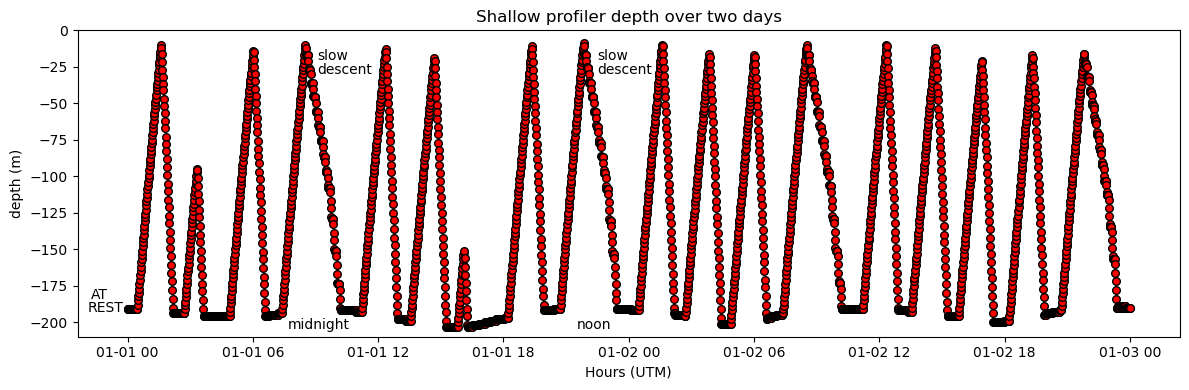

In [1]:
from matplotlib import pyplot as plt
from shallowprofiler import sensors
from data import *

print('\nJupyter Notebook running Python {}'.format(sys.version_info[0]))


def ProfilerDepthChart(t0, t1, fnm):
    ds = xr.open_dataset(fnm).sel(time=slice(dt64(t0), dt64(t1)))           # this is not profiler metadata. It is actual sensor data.
    fig, axs = plt.subplots(figsize=(12,4), tight_layout=True)
    axs.plot(ds.time, ds.z, marker='.', ms=11., color='k', mfc='r', linewidth='.0001')
    axs.set(ylim = (-210., 0.), title='Shallow profiler depth over two days', ylabel='depth (m)', xlabel='Hours (UTM)')
    axs.text(dt64('2021-12-31 22:15'), -184, 'AT')
    axs.text(dt64('2021-12-31 22:05'), -193, 'REST')
    axs.text(dt64('2022-01-01 07:40'), -205, 'midnight')
    axs.text(dt64('2022-01-01 21:30'), -205, 'noon')
    axs.text(dt64('2022-01-01 09:05'), -20, 'slow')
    axs.text(dt64('2022-01-01 09:05'), -30, 'descent')
    axs.text(dt64('2022-01-01 22:30'), -20, 'slow')
    axs.text(dt64('2022-01-01 22:30'), -30, 'descent')
    return True
    

ProfilerDepthChart('2022-01-01', '2022-01-03', './data/rca/sensors/osb/ctd_jan22_conductivity.nc')  # index [0] is arbitrary; any dataset will include z data


def VisualizeProfiles(date_id, n_days, year_id, month_id, month_name, site_name):
    ds = xr.open_dataset('./data/rca/sensors/osb/ctd_jan22_conductivity.nc')
    fig, axs = plt.subplots(n_days, 1, figsize=(15,n_days), tight_layout=True)

    for i in range(n_days):
        daystring = str(i+1) if i > 8 else '0' + str(i+1)
        time0 = dt64(year_id + '-' + month_id + '-' + daystring + 'T00:00:00')
        time1 = dt64(year_id + '-' + month_id + '-' + daystring + 'T23:59:59')
        dsDay = ds.sel(time=slice(time0, time1))
        axs[i].plot(dsDay.time, dsDay.z, marker='.', markersize=3., color='k')
        axs[i].set(ylim = (-200., 0.))

    print('...' + month_name + ' ' + str(year_id) + ' ' + site_name + ' daily profiles...')
    return True


# Enable this code for a more expansive view of the January 2022 Oregon Slope Base shallow profiler depth history.
if False: VisualizeProfiles('jan22', 31, '2022', '01', 'January', 'Oregon Slope Base')


#### How to use profile files

- Read the file into a pandas Dataframe
- Each row is a Rest --- Ascent --- Descent phase sequence
    - Each phase has a start and an end: For a total of six events
        - There is degeneracy: r1 == a0, a1 == d0, and mostly d1 == the next row's r0
    - Each entry for these six events is a triple (i, t, z)
        - i is an index from the source file; usually ignore this
        - t is the time of the event; important
        - z is the depth of the event
            - for a1/d0 this will indicate if the profile approached the surface
    - Consequently each row has 18 columns
    
Suppose the idea is to make a depth plot of temperature for a particular profile. Select out this
profile and slice the source data using a time range given as a0 to a1. See the next notebook 
for examples.


#### Comment on profile phase durations


```
  Ascents:   67.4 +-3.0  minutes
  Descents:  vary depending: midnight/noon descents are slow (70 minutes); otherwise quick (20 minutes)
  Rests:     vary with descent, 30 / 60 minutes
```

### Example use of profile metadata


The following cell reads January 2022 Oregon Slope Base metadata into a pandas DataFrame 'profiles'.
In so doing it converts the information from text to pandas Timestamps. The rows of the resulting 
DataFrame correspond to consecutive profiles. The columns correspond to (time depth)
pairs: r0t is rest start time. r0z is depth at that time. r1t is rest end time.
r1z is depth at that time (typically close to r0z). Following this are a0, a1 for 
ascent and d0, d1 for descent. There is some degeneracy in this metadata as the 
end of the ascent corresponds to the start of the descent.

January has 31 days so there are a maximum of 279 possible profiles.

In [2]:
from shallowprofiler import *
from charts import *

profiles = ReadProfileMetadata()
profiles

,r0t,r0z,r1t,r1z,a0t,a0z,a1t,a1z,d0t,d0z,d1t,d1z
0,2022-01-01 00:00:00,-191.0,2022-01-01 00:22:00,-191.0,2022-01-01 00:22:00,-191.0,2022-01-01 01:32:00,-19.0,2022-01-01 01:32:00,-19.0,2022-01-01 02:11:00,-194.0
1,2022-01-01 02:11:00,-194.0,2022-01-01 02:37:00,-194.0,2022-01-01 02:37:00,-194.0,2022-01-01 03:15:00,-105.0,2022-01-01 03:15:00,-105.0,2022-01-01 03:38:00,-196.0
2,2022-01-01 03:38:00,-196.0,2022-01-01 04:47:00,-196.0,2022-01-01 04:47:00,-196.0,2022-01-01 05:57:00,-24.0,2022-01-01 05:57:00,-24.0,2022-01-01 06:36:00,-196.0
3,2022-01-01 06:36:00,-196.0,2022-01-01 07:17:00,-194.0,2022-01-01 07:17:00,-194.0,2022-01-01 08:30:00,-12.0,2022-01-01 08:30:00,-12.0,2022-01-01 10:12:00,-192.0
4,2022-01-01 10:12:00,-192.0,2022-01-01 11:07:00,-193.0,2022-01-01 11:07:00,-193.0,2022-01-01 12:17:00,-23.0,2022-01-01 12:17:00,-23.0,2022-01-01 12:56:00,-198.0
...,...,...,...,...,...,...,...,...,...,...,...,...
274,2022-01-31 12:53:00,-190.0,2022-01-31 11:07:00,-191.0,2022-01-31 11:07:00,-191.0,2022-01-31 12:15:00,-23.0,2022-01-31 12:15:00,-23.0,2022-01-31 15:15:00,-191.0
275,2022-01-31 15:15:00,-191.0,2022-01-31 13:27:00,-190.0,2022-01-31 13:27:00,-190.0,2022-01-31 14:36:00,-20.0,2022-01-31 14:36:00,-20.0,2022-01-31 17:31:00,-193.0
276,2022-01-31 17:31:00,-193.0,2022-01-31 15:42:00,-191.0,2022-01-31 15:42:00,-191.0,2022-01-31 16:52:00,-20.0,2022-01-31 16:52:00,-20.0,2022-01-31 19:56:00,-193.0
277,2022-01-31 19:56:00,-193.0,2022-01-31 18:07:00,-193.0,2022-01-31 18:07:00,-193.0,2022-01-31 19:17:00,-20.0,2022-01-31 19:17:00,-20.0,2022-01-31 23:32:00,-193.0


In [3]:
# profile time access syntax:
profile_row_index = 0
tA0, tA1 = profiles['a0t'][profile_row_index], profiles['a1t'][profile_row_index]
print(tA0, tA1, 'Time difference:', tA1 - tA0)
print('Type of these times:', type(tA0))

2022-01-01 00:22:00 2022-01-01 01:32:00 Time difference: 0 days 01:10:00
Type of these times: <class 'pandas._libs.tslibs.timestamps.Timestamp'>


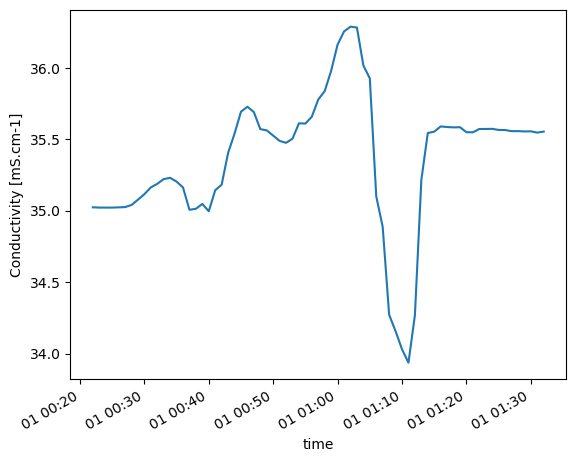

In [4]:
ds = xr.open_dataset('./data/rca/sensors/osb/ctd_jan22_conductivity.nc')
ds_timebox = ds.sel(time=slice(tA0, tA1))
ds_timebox.conductivity.plot()

## Sensor Data


In the preceding section we accessed some conductivity data from Oregon Slope Base circa
January 2022. This section connects more formally to these existing sensor datasets.



In [5]:
base_path = './data/rca/sensors/'
date_id   = 'jan22'
site_id   = 'osb'

data_file_list = []
for s in sensors:
    data_file_list.append(base_path + site_id + '/' + s[1] + '_' + date_id + '_' + s[0] + '.nc')   # example result: 'osb/ctd_jan22_temperature.nc'

!ls -al ./data/rca/sensors/osb/ctd_jan22_conductivity.nc

# relative path to data files is base_path + site_id + '/'
# The data variables corresponding to the jan22_data filenames in data_file_list[]:
month_data_vars = [
    ['pressure'],['temperature'],['density'], ['salinity'], ['conductivity'],
    ['fdom'], ['chlora'], ['bb'],
    ['spkir412nm', 'spkir443nm', 'spkir490nm', 'spkir510nm', 'spkir555nm', 'spkir620nm', 'spkir683nm'],
    ['nitrate'],
    ['pco2'],
    ['do'],
    ['par'],
    ['ph'],
    ['up'], ['east'], ['north']
    ]

-rw-r--r-- 1 rob rob 894104 Jun 16 17:20 ./data/rca/sensors/osb/ctd_jan22_conductivity.nc


### Dataset check


The above cell creates `data_file_list`: A list of time-bounded NetCDF sensor measurement files (in-repo). 
To review these files in more detail:
    

```
ds = xr.open_dataset(data_file_list[0])
print(ds)
```

In [7]:
# This cell assembles a data dictionary "d" from the OOI datasets

d = {}                 # empty Python dictionary

relative_path = './data/rca/sensors/'
sitestring = 'osb'                    # available: osb = Oregon Slope Base
monthstring = 'jan22'                 # available: apr21, jul21, jan22

def GetSensorTuple(s, f):
    '''
    s is the sensor identifier string like 'temperature'
        It is actually a 2-element list: [0] is the sensor, [1] is the instrument
    f is the source filename like './../data/osb_ctd_jan22_temperature.nc' 
    '''
    df_sensor    = xr.open_dataset(f)[s]
    df_z         = xr.open_dataset(f)['z']
    range_lo     = ranges[s][0]
    range_hi     = ranges[s][1]
    sensor_color = colors[s]
    return (df_sensor, df_z, range_lo, range_hi, sensor_color)

for sensor in sensors:          # sensor is a list of 2 strings [sensor_str, instrument_str]
    f = relative_path + sitestring + '/' + sensor[1] + '_' + monthstring + '_' + sensor[0] + '.nc'
    d[sensor[0]] = GetSensorTuple(sensor[0], f)

Attempting 1 charts



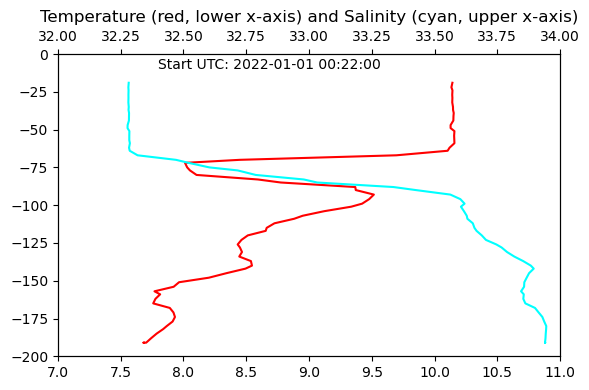

In [8]:
# temperature and salinity
fig,axs = ChartTwoSensors(profiles, [ranges['temperature'], ranges['salinity']], [0], 
                          d['temperature'][0], d['temperature'][1], 'Temperature', colors['temperature'],    'ascent',
                          d['salinity'][0],       d['salinity'][1],    'Salinity',  colors['salinity'], 'ascent', 6, 4)

**Note: The above chart shows a temperature excursion to the left at a depth of about 75 meters (red). 
There is not a corresponding excursion in the salinity (cyan), this illustrating a *lack* of coincidence.**

Attempting 1 charts



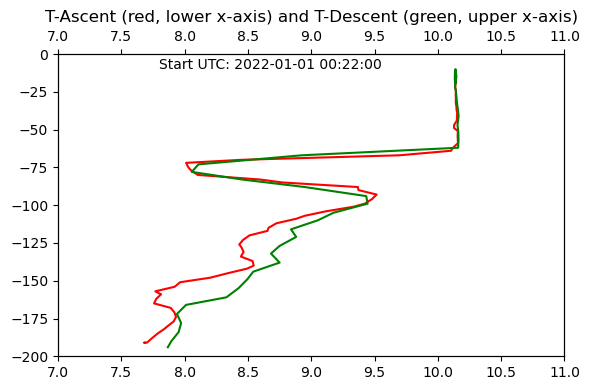

In [9]:
# temperature: ascent versus descent
fig,axs = ChartTwoSensors(profiles, [ranges['temperature'], ranges['temperature']], [0], 
                          d['temperature'][0], d['temperature'][1], 'T-Ascent',   colors['temperature'],    'ascent',
                          d['temperature'][0], d['temperature'][1], 'T-Descent',  'green',                  'descent', 6, 4)

**Note: The above chart compares profile temperature on ascent (red) with the subsequent descent (green). 
The cold excursion noted above is present in both profiles. The temperature structure below 100 meters
is similar but less well-matched. This is an initial view of what we can expect for *stability*.**

In [10]:
# this cell connects to the RCA Zarr filesystem on the cloud and lists available data streams
import netCDF4
import xarray as xr
import s3fs

fs = s3fs.S3FileSystem(anon=True)

streamlist = fs.listdir('ooi-data', detail = False)

def InstrumentBreakout(s):
    print('Field breakout:', s[9:11], s[11:13], s[13:15], s[15:17], s[18:20], s[20:22], s[22:23], s[24:26], \
          s[27:32], s[32:33], s[33:36], s[46:])

print('List Oregon Slope Base Profiler streams:\n')
for s in streamlist:
    if 'SF01A' in s: print(s)
print()
print('Translation:')
print('  CTDPF / ctdpf                 CTD')
print('  PHSEN / phsen                 pH')
print('  FLORT / flort                 Fluorometer { FDOM, Chlor-A, Backscatter }')
print('  OPTAA / optaa                 Spectrophotometer') 
print('  PARAD / parad                 PAR')
print('  SPKIR / spkir                 Spectral Irradiance')
print('  NUTNR / nutnr_a_dark_sample   Nitrate: Dark sample (explain please)')
print('  NUTNR / nutnr_a_sample        Nitrate: ...')
print('  VELPT / velpt                 Velocity (current) ambiguous: on SCIP or affixed to platform?')
print('  PCO2W / pco2w                 pCO2')
print()

stream_choice = 15       # the 15th element in the file list corresponds to the Shallow Profiler, Oregon Slope Base site

print()
print('Full stream name:', streamlist[stream_choice])
print()
InstrumentBreakout(streamlist[stream_choice])
print()
print('The first field has CE for Coastal Endurance or RS for Regional Cabled Array.')
print('Fields 5, 6 and 7 give us shallow profiler site and choice of profiler or platform.')
print()
indenter = 4
print(' '*indenter + 'PC 01 B --> Oregon Offshore 200m Platform')
print(' '*indenter + 'SF 01 B --> Oregon Offshore Profiler')
print(' '*indenter + 'PC 01 A --> Oregon Slope Base Profiler')
print(' '*indenter + 'SF 01 A --> Oregon Slope Base Profiler')
print(' '*indenter + 'PC 03 A --> Axial Base 200m Platform')
print(' '*indenter + 'SF 03 A --> Axial Base Profiler')
print()
print('Non-shallow-profiler examples:')
print('  DP O3 A is the Axial Base Deep Profiler')
print('  LJ 01 A is the Oregon Slope Base Seafloor')
print()

List Oregon Slope Base Profiler streams:

ooi-data/RS01SBPS-SF01A-2A-CTDPFA102-streamed-ctdpf_sbe43_sample
ooi-data/RS01SBPS-SF01A-2D-PHSENA101-streamed-phsen_data_record
ooi-data/RS01SBPS-SF01A-3A-FLORTD101-streamed-flort_d_data_record
ooi-data/RS01SBPS-SF01A-3B-OPTAAD101-streamed-optaa_sample
ooi-data/RS01SBPS-SF01A-3C-PARADA101-streamed-parad_sa_sample
ooi-data/RS01SBPS-SF01A-3D-SPKIRA101-streamed-spkir_data_record
ooi-data/RS01SBPS-SF01A-4A-NUTNRA101-streamed-nutnr_a_dark_sample
ooi-data/RS01SBPS-SF01A-4A-NUTNRA101-streamed-nutnr_a_sample
ooi-data/RS01SBPS-SF01A-4B-VELPTD102-streamed-velpt_velocity_data
ooi-data/RS01SBPS-SF01A-4F-PCO2WA101-streamed-pco2w_a_sami_data_record

Translation:
  CTDPF / ctdpf                 CTD
  PHSEN / phsen                 pH
  FLORT / flort                 Fluorometer { FDOM, Chlor-A, Backscatter }
  OPTAA / optaa                 Spectrophotometer
  PARAD / parad                 PAR
  SPKIR / spkir                 Spectral Irradiance
  NUTNR / nutnr_

In [11]:
from shallowprofiler import *
from charts import *

def loadData(stream_name):
    fs = s3fs.S3FileSystem(anon=True)
    zarr_store = fs.get_mapper(stream_name)
    ds = xr.open_zarr(zarr_store, consolidated=True)
    return ds

def SPDataReduce(ds, t0, t1, keepers, rename):
    """
    From a zarr Dataset for a shallow profiler stream ('ds') write a NetCDF file with just 
    time/sensor-value/depth over a time period typically no longer than a month.
      - check that the dimension and coordinate is 'time'
      - drop or rename data vars
      - drop attributes
    """
    if not len(ds.dims) == 1: 
        return False, "Dataset dims count is not 1 (as assumed)"
    if not list(dict(ds.dims))[0] == 'time': 
        return False, "Dataset dim is not 'time' (as assumed)"
    if not len(ds.coords) == 1: 
        return False, "Dataset coords count is not 1 (as assumed)"
    if not list(dict(ds.coords))[0] == 'time': 
        return False, "Dataset coord is not 'time' (as assumed)"
    
    ds = ds.sel(time=slice(t0, t1))
    
    for s in ds.data_vars:
        if not s in keepers: ds = ds.drop(s)                              # drop extraneous data vars
    for s in ds.data_vars: ds = ds.rename({s:rename[keepers.index(s)]})   # rename the others
    a = [s for s in ds.attrs]
    for p in a: ds.attrs.pop(p)
    return ds, 'looks ok'


if False:    
    osb_profiler_streams = [sname for sname in streamlist if 'SF01A' in sname]
    for s in osb_profiler_streams: 
        if 'ctdpf' in s: osb_sp_ctd = s

    print('OSB CTD stream:', osb_sp_ctd)
    print()

    siteData = loadData(osb_sp_ctd)

    print('site data is now lazy-loaded\n')
    print(siteData.time[-1])


    profiles = ReadProfileMetadata()    # this is an error: Hardcoded for Jan 2022
    how_many_charts = 1
    profile_list = [n for n in range(how_many_charts)]   # quick check: use d['temperature'].z.plot()

    t0, t1 = '2022-01-01T00', '2022-12-31T23'
    ds = siteData.sel(time=slice(t0, t1))
    ds.time[0], ds.time[-1]

    t0, t1 = '2022-01-01T00', '2022-01-31T23'
    ds_reduced, reply = SPDataReduce(ds, t0, t1, ['sea_water_temperature', 'sea_water_pressure'], 
                                 ['temperature', 'depth'], )
    print(reply)
    print(ds_reduced)
    ds_reduced.to_netcdf('osb_temp_jan_2022.nc') 

Attempting 1 charts



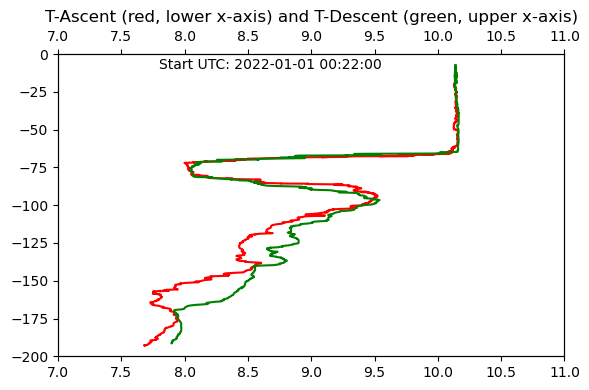

In [12]:
ds_zarr = xr.open_dataset('./data/rca/sensors/osb/zarr/temperature_jan_2022.nc')

# temperature: ascent versus descent
fig,axs = ChartTwoSensors(profiles, [ranges['temperature'], ranges['temperature']], [0], 
                          ds_zarr.temperature, -ds_zarr.depth,
                          'T-Ascent',   colors['temperature'],    'ascent',
                          ds_zarr.temperature, -ds_zarr.depth,
                          'T-Descent',  'green',                  'descent', 6, 4)

Attempting 1 charts



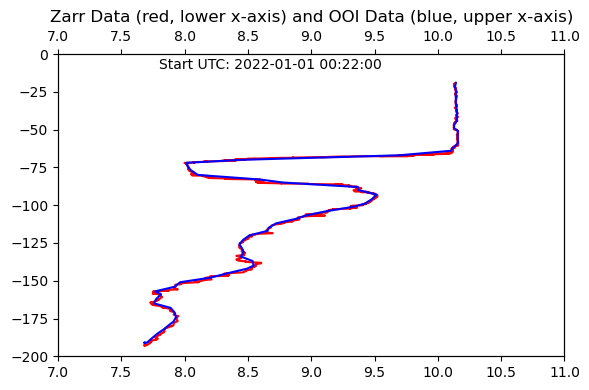

In [13]:
# temperature: ascent versus descent
fig,axs = ChartTwoSensors(profiles, [ranges['temperature'], ranges['temperature']], [0], 
                          ds_zarr.temperature, -ds_zarr.depth,
                          'Zarr Data',   colors['temperature'],    'ascent',
                          d['temperature'][0], d['temperature'][1], 'OOI Data',   'blue',    'ascent', 6, 4)

Fossil code:

```
df   = ds.to_dataframe()
vals = [xr.DataArray(data=df[c], dims=['time'], coords={'time':df.index}, attrs=ds[c].attrs) for c in df.columns]
ds   = xr.Dataset(dict(zip(df.columns, vals)), attrs=ds.attrs)
```